<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://cdn.miami.edu/_assets-common/images/system/um-logo-gray-bg.png" alt="Miami Logo" style="height: 98px;">
</div>

<div style="float:right; width:98 px; height:98px;">
<img src="https://media.licdn.com/dms/image/C4E0BAQFlOZSAJABP4w/company-logo_200_200/0/1548285168598?e=2147483647&v=beta&t=g4jl8rEhB7HLJuNZhU6OkJWHW4cul_y9Kj_aoD7p0_Y" alt="STI Logo" style="height: 98px;">
</div>


<h1>Visualize and Compare Timeseries of sFWRD at Observational Stations</h1>
By: Kayla Besong, PhD
    <br>
Last Edited: 05/06/24
<br>
<br>    
<br>
Compare database files with observations at GACC locations across the US. The notebook utilizes data produced in Point_Selection.ipynb. Two options: one to plot multiple variables at one station, one variable at multiple stations, or one variable one station multiple times. <div style="clear:both"></div>
</div>

<hr style="height:2px;">

## Import needed libraries, etc.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from dask.distributed import Client, LocalCluster
import dask.array as da
import os
import glob


In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
pd.options.mode.chained_assignment = None

# The integral notebook of functions to run + some others

In [3]:
%run ../../../../Universal_Functions/File_concat_mod_functions.ipynb

In [48]:
def convert(ds, variable, obs_v_mod, m = None):


    ''' Function to convert observational or model data for plotting.

    Inputs:
    ds: (xarray dataarray) input dataarray that needs converted
    variable: (str) the variable being converted
    obs_v_mod: (str) if the dataarray being converted is model or obs data
    m: (str) optional model name to aid in cases where some models needed converted and others do not

    Outputs:

    ds: (xarray dataarray) the converted dataarray
    '''    

    if variable == 'temp':

        if obs_v_mod == 'obs':

            ds = (ds*(9./5.))+32
        
        else:

            ds = ((ds - 273.15)*(9./5.))+32

    elif variable == 'rh':

        if m == 'ERA5' or m == 'HRRR' or m == 'CONUS404':

            ds = ds*100

    elif variable == 'hdwi':

        if obs_v_mod == 'obs':

            ds = ds/100.0

    return ds
            

# Multiple Stations, One Variable

## Get observation files by variable and station

In [12]:
sites = pd.read_csv('obs/SiteList_LatLon.csv', sep = ',')

In [13]:
site_list = sites['Site'].values
site_list

array(['KPDX', 'KRDD', 'PHKO', 'KRAL', 'KSLC', 'PAFA', 'KABQ', 'KMSO',
       'KDEN', 'KATL', 'KMKE'], dtype=object)

In [14]:
sites

Site  Latitude  Longitude  Elevation-Ft  Elevation-Meter
0   KPDX  45.59578 -122.60917            20              6.1
1   KRDD  40.51461 -122.29770           499            152.1
2   PHKO  19.74083 -156.05056            43             13.1
3   KRAL  33.95189 -117.44511           819            249.6
4   KSLC  40.77069 -111.96503          4226           1288.0
5   PAFA  64.80389 -147.87611           433            132.0
6   KABQ  35.04167 -106.61472          5351           1630.9
7   KMSO  46.92083 -114.09250          3199            975.0
8   KDEN  39.84658 -104.65622          5404           1647.1
9   KATL  33.64028  -84.42694          1027            313.0
10  KMKE  42.95500  -87.90444           722            220.1

In [62]:
obs_to_mod_var = {'temp': 't2',
                  'rh': 'rh',
                  'windspeed': 'ws',
                  'winddir': 'wd',
                  'windgust': 'gust',
                  'precip_1hr': 'tp',
                  'vpd': 'vpd',
                  'hdwi': 'hdw'  
}

In [63]:
models =  ['ERA5', 'NCEP', 'CONUS404', 'NAM', 'NARR', 'HRRR']

In [110]:
%%time                                                                                                                                
                          
t = 'Abs'                                                                                                                             # Set the type of data to 'Abs'
to_plot = {}
                            
for sitename in site_list:                                                                                                            # Loop through each site name in site_list
                            
    dir_maker(f'obs/model_by_site/{sitename}')                                                                                        # Create a directory for the current site
                            
    print(f'{sitename} IS STARTING')                                                                                                  # Print a message indicating the start of processing for the current site

    site_mod = {}
    site_obs = {}
    
    for obs_v, mod_v in obs_to_mod_var.items():                                                                                       # Loop through each observation variable and its corresponding model variable
        
        obs = xr.open_mfdataset(glob.glob(os.path.join('obs/database_like_files', f'{obs_v}*{sitename}*{t}*.nc')))                    # Open the observation dataset for the current variable and site
        
        site_mod_var = {}
        
        for m in models:                                                                                                              # Loop through each model
                            
            dir_maker(f'obs/model_by_site/{sitename}/{m}')                                                                            # Create a directory for the current model
                            
            print(f'{m}: {mod_v}')                                                                                                    # Print a message indicating the current model and variable

            try:
        
                mod = xr.open_dataset(f'obs/model_by_site/{sitename}/{m}/{mod_v}_{m}_{sitename}.nc')
    
                site_mod_var[m] = mod      
                                         
            except:                                                                                                                    # Handle exceptions
                             
                print(f'{m}: {mod_v} is not available')                                                                                # Print a message indicating the model variable is not available

        site_obs[obs_v] = obs.resample(time = '24H').mean('time')                                                                      # Resample the data to match daily frequencies 
        site_mod[obs_v] = site_mod_var                             
                                                                                                                                       # Delete the selected model data to free up memory
    to_plot[sitename] = [site_obs, site_mod]


KPDX IS STARTING
ERA5: t2
NCEP: t2
CONUS404: t2
NAM: t2
NARR: t2
HRRR: t2
ERA5: rh
NCEP: rh
CONUS404: rh
NAM: rh
NARR: rh
HRRR: rh
ERA5: ws
NCEP: ws
CONUS404: ws
NAM: ws
NARR: ws
HRRR: ws
ERA5: wd
NCEP: wd
CONUS404: wd
NAM: wd
NARR: wd
HRRR: wd
ERA5: gust
NCEP: gust
NCEP: gust is not available
CONUS404: gust
CONUS404: gust is not available
NAM: gust
NARR: gust
NARR: gust is not available
HRRR: gust
ERA5: tp
NCEP: tp
NCEP: tp is not available
CONUS404: tp
NAM: tp
NARR: tp
HRRR: tp
ERA5: vpd
NCEP: vpd
CONUS404: vpd
NAM: vpd
NARR: vpd
HRRR: vpd
ERA5: hdw
NCEP: hdw
CONUS404: hdw
NAM: hdw
NARR: hdw
HRRR: hdw
KRDD IS STARTING
ERA5: t2
NCEP: t2
CONUS404: t2
NAM: t2
NARR: t2
HRRR: t2
ERA5: rh
NCEP: rh
CONUS404: rh
NAM: rh
NARR: rh
HRRR: rh
ERA5: ws
NCEP: ws
CONUS404: ws
NAM: ws
NARR: ws
HRRR: ws
ERA5: wd
NCEP: wd
CONUS404: wd
NAM: wd
NARR: wd
HRRR: wd
ERA5: gust
NCEP: gust
NCEP: gust is not available
CONUS404: gust
CONUS404: gust is not available
NAM: gust
NARR: gust
NARR: gust is not availabl

## Plotting 

In [73]:
ordered_sites = ['KPDX', 'KRDD', 'KRAL', 'KSLC', 'KABQ', 'KMSO',
       'KDEN', 'KATL', 'KMKE', 'PHKO', 'PAFA']

In [74]:
var_plot_dict = {'temp': ['t2', 'Temperature', '$^\circ$F'],
                  'rh': ['rh', 'Relative Humidity', '%'],
                  'windspeed': ['ws', 'Wind Speed', 'm/s'],
                  'winddir': ['wd', 'Wind Direction', 'Degrees'],
                  'windgust': ['gust', 'Wind Gust', 'm/s'],
                  'precip_1hr': ['tp', 'Total Precipitation', 'm'],
                  'vpd': ['vpd', 'Vapor Pressure Deficit', 'hPa'],
                  'hdwi': ['hdw', 'Surface Based Hot-Dry-Windy', '']
}

In [75]:
vars = list(var_plot_dict.keys())
vars

['temp', 'rh', 'windspeed', 'winddir', 'windgust', 'precip_1hr', 'vpd', 'hdwi']

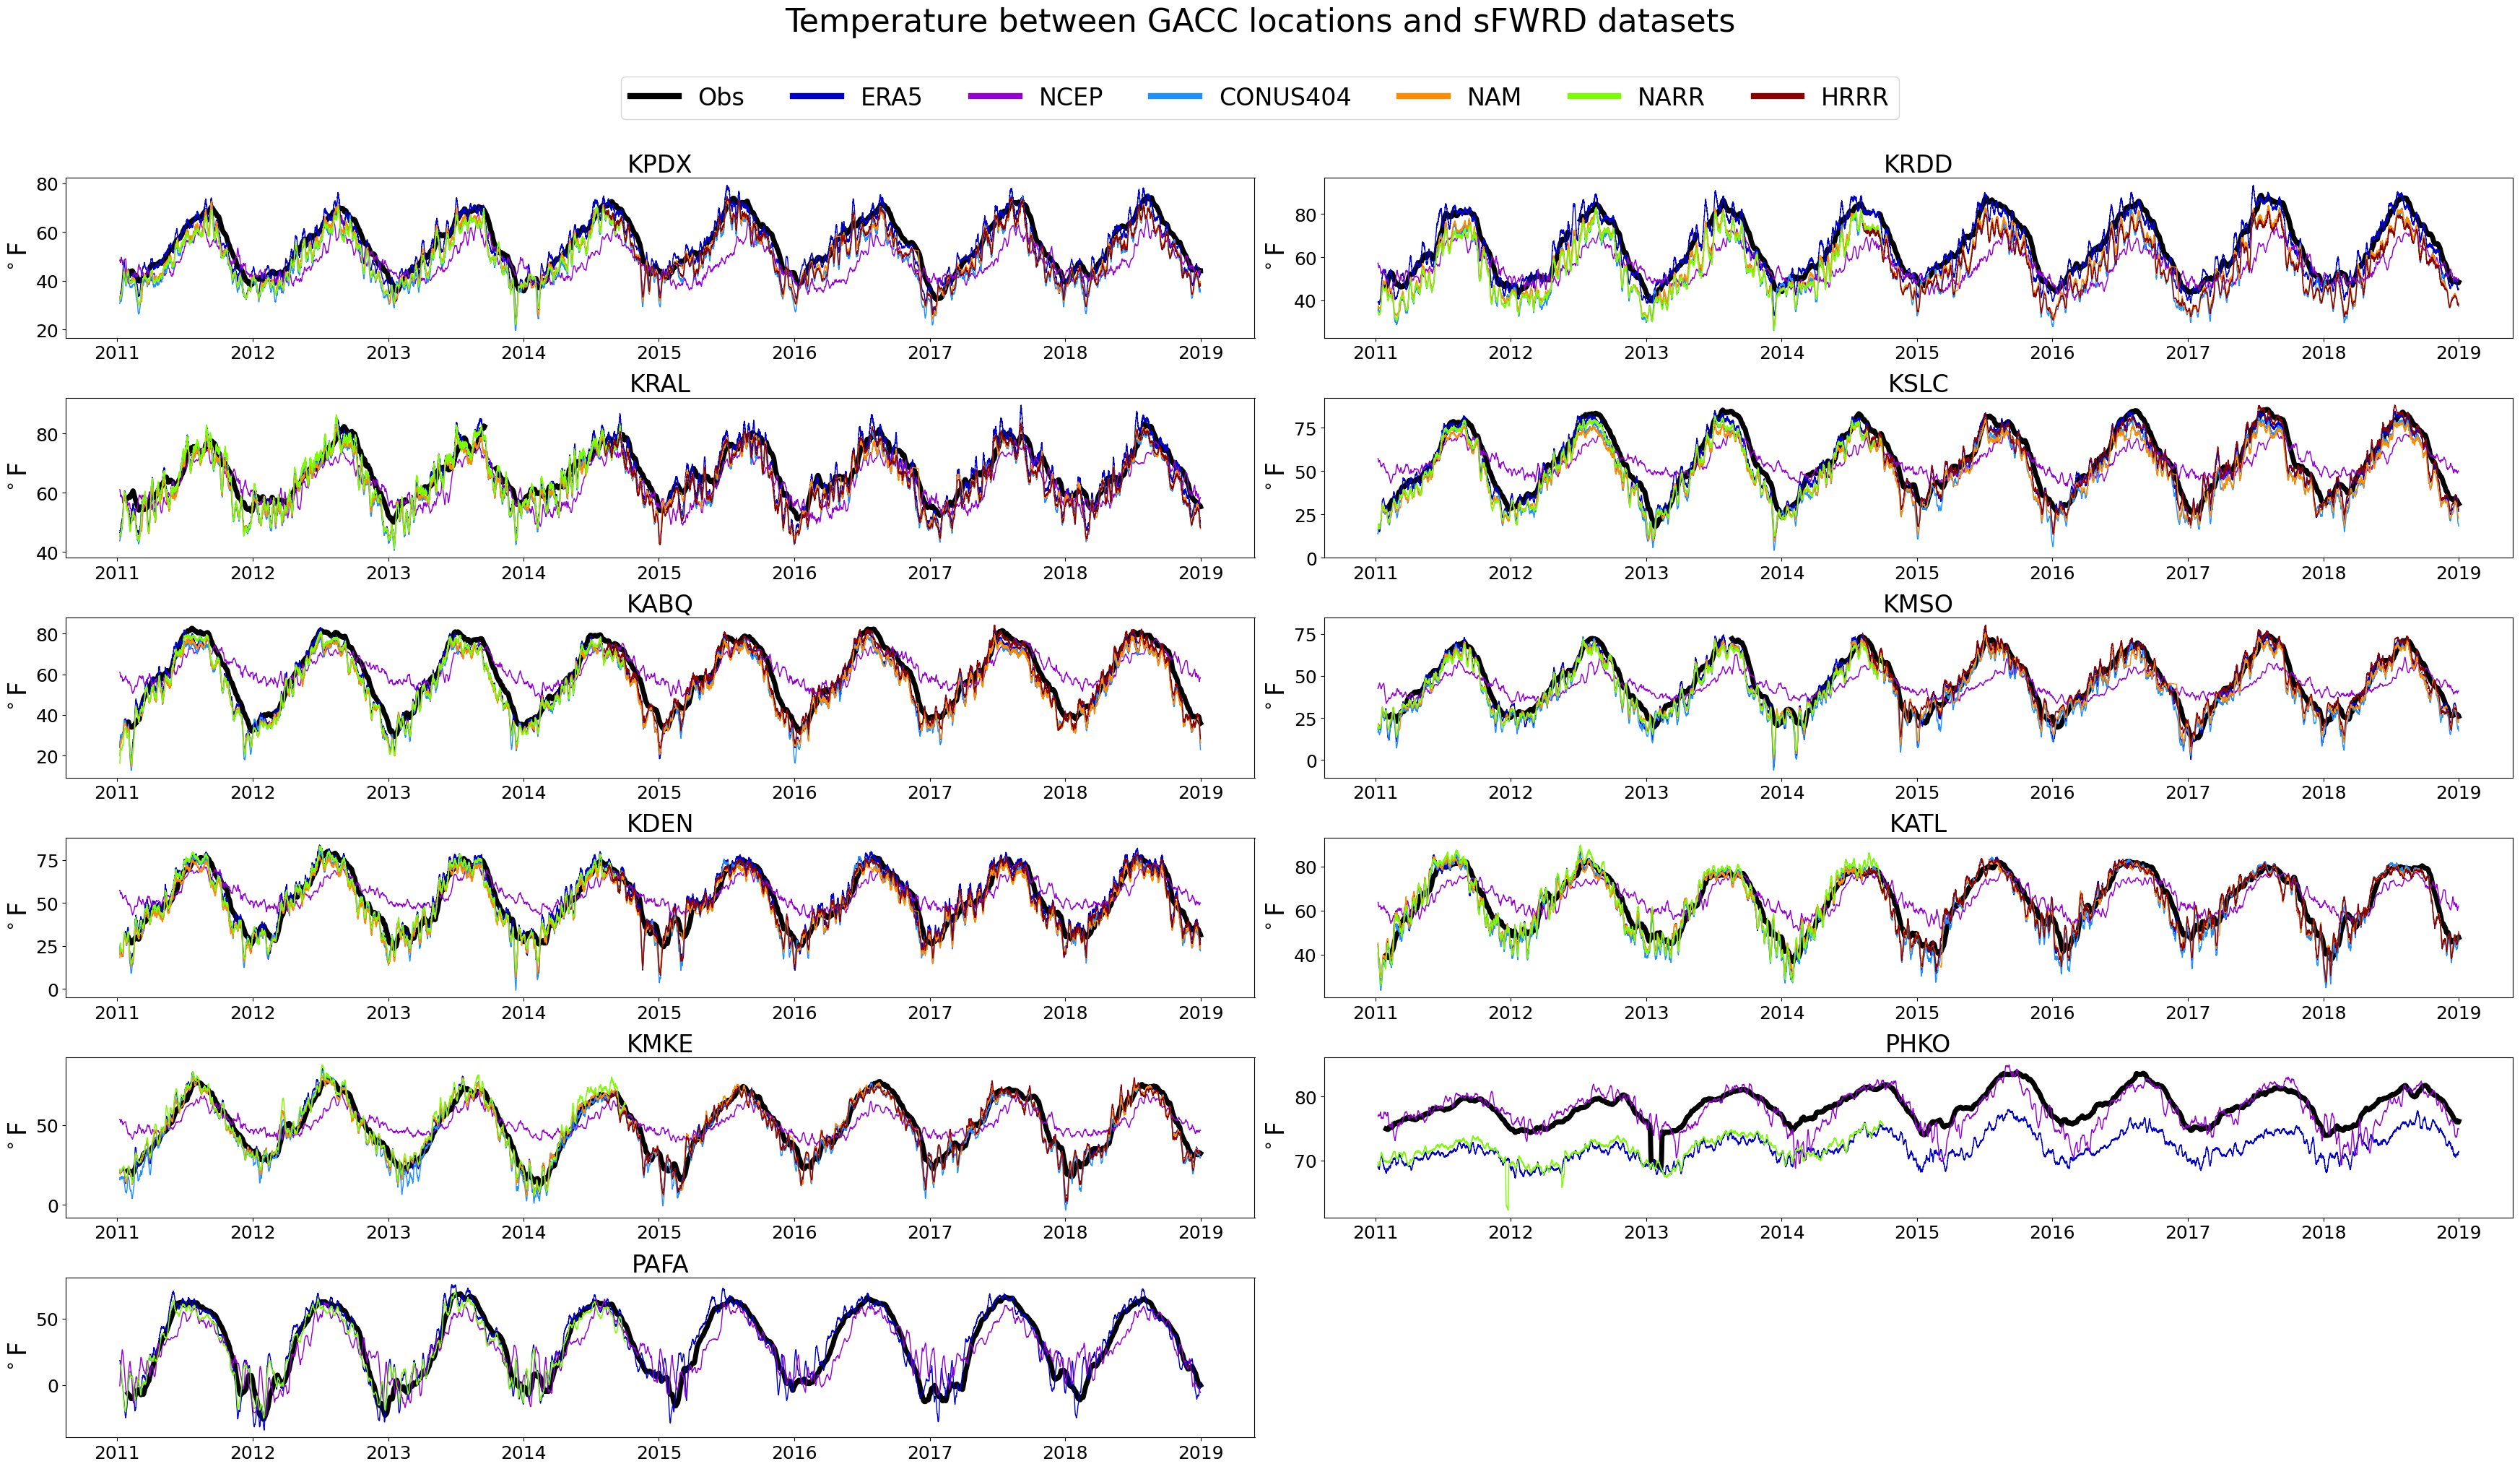

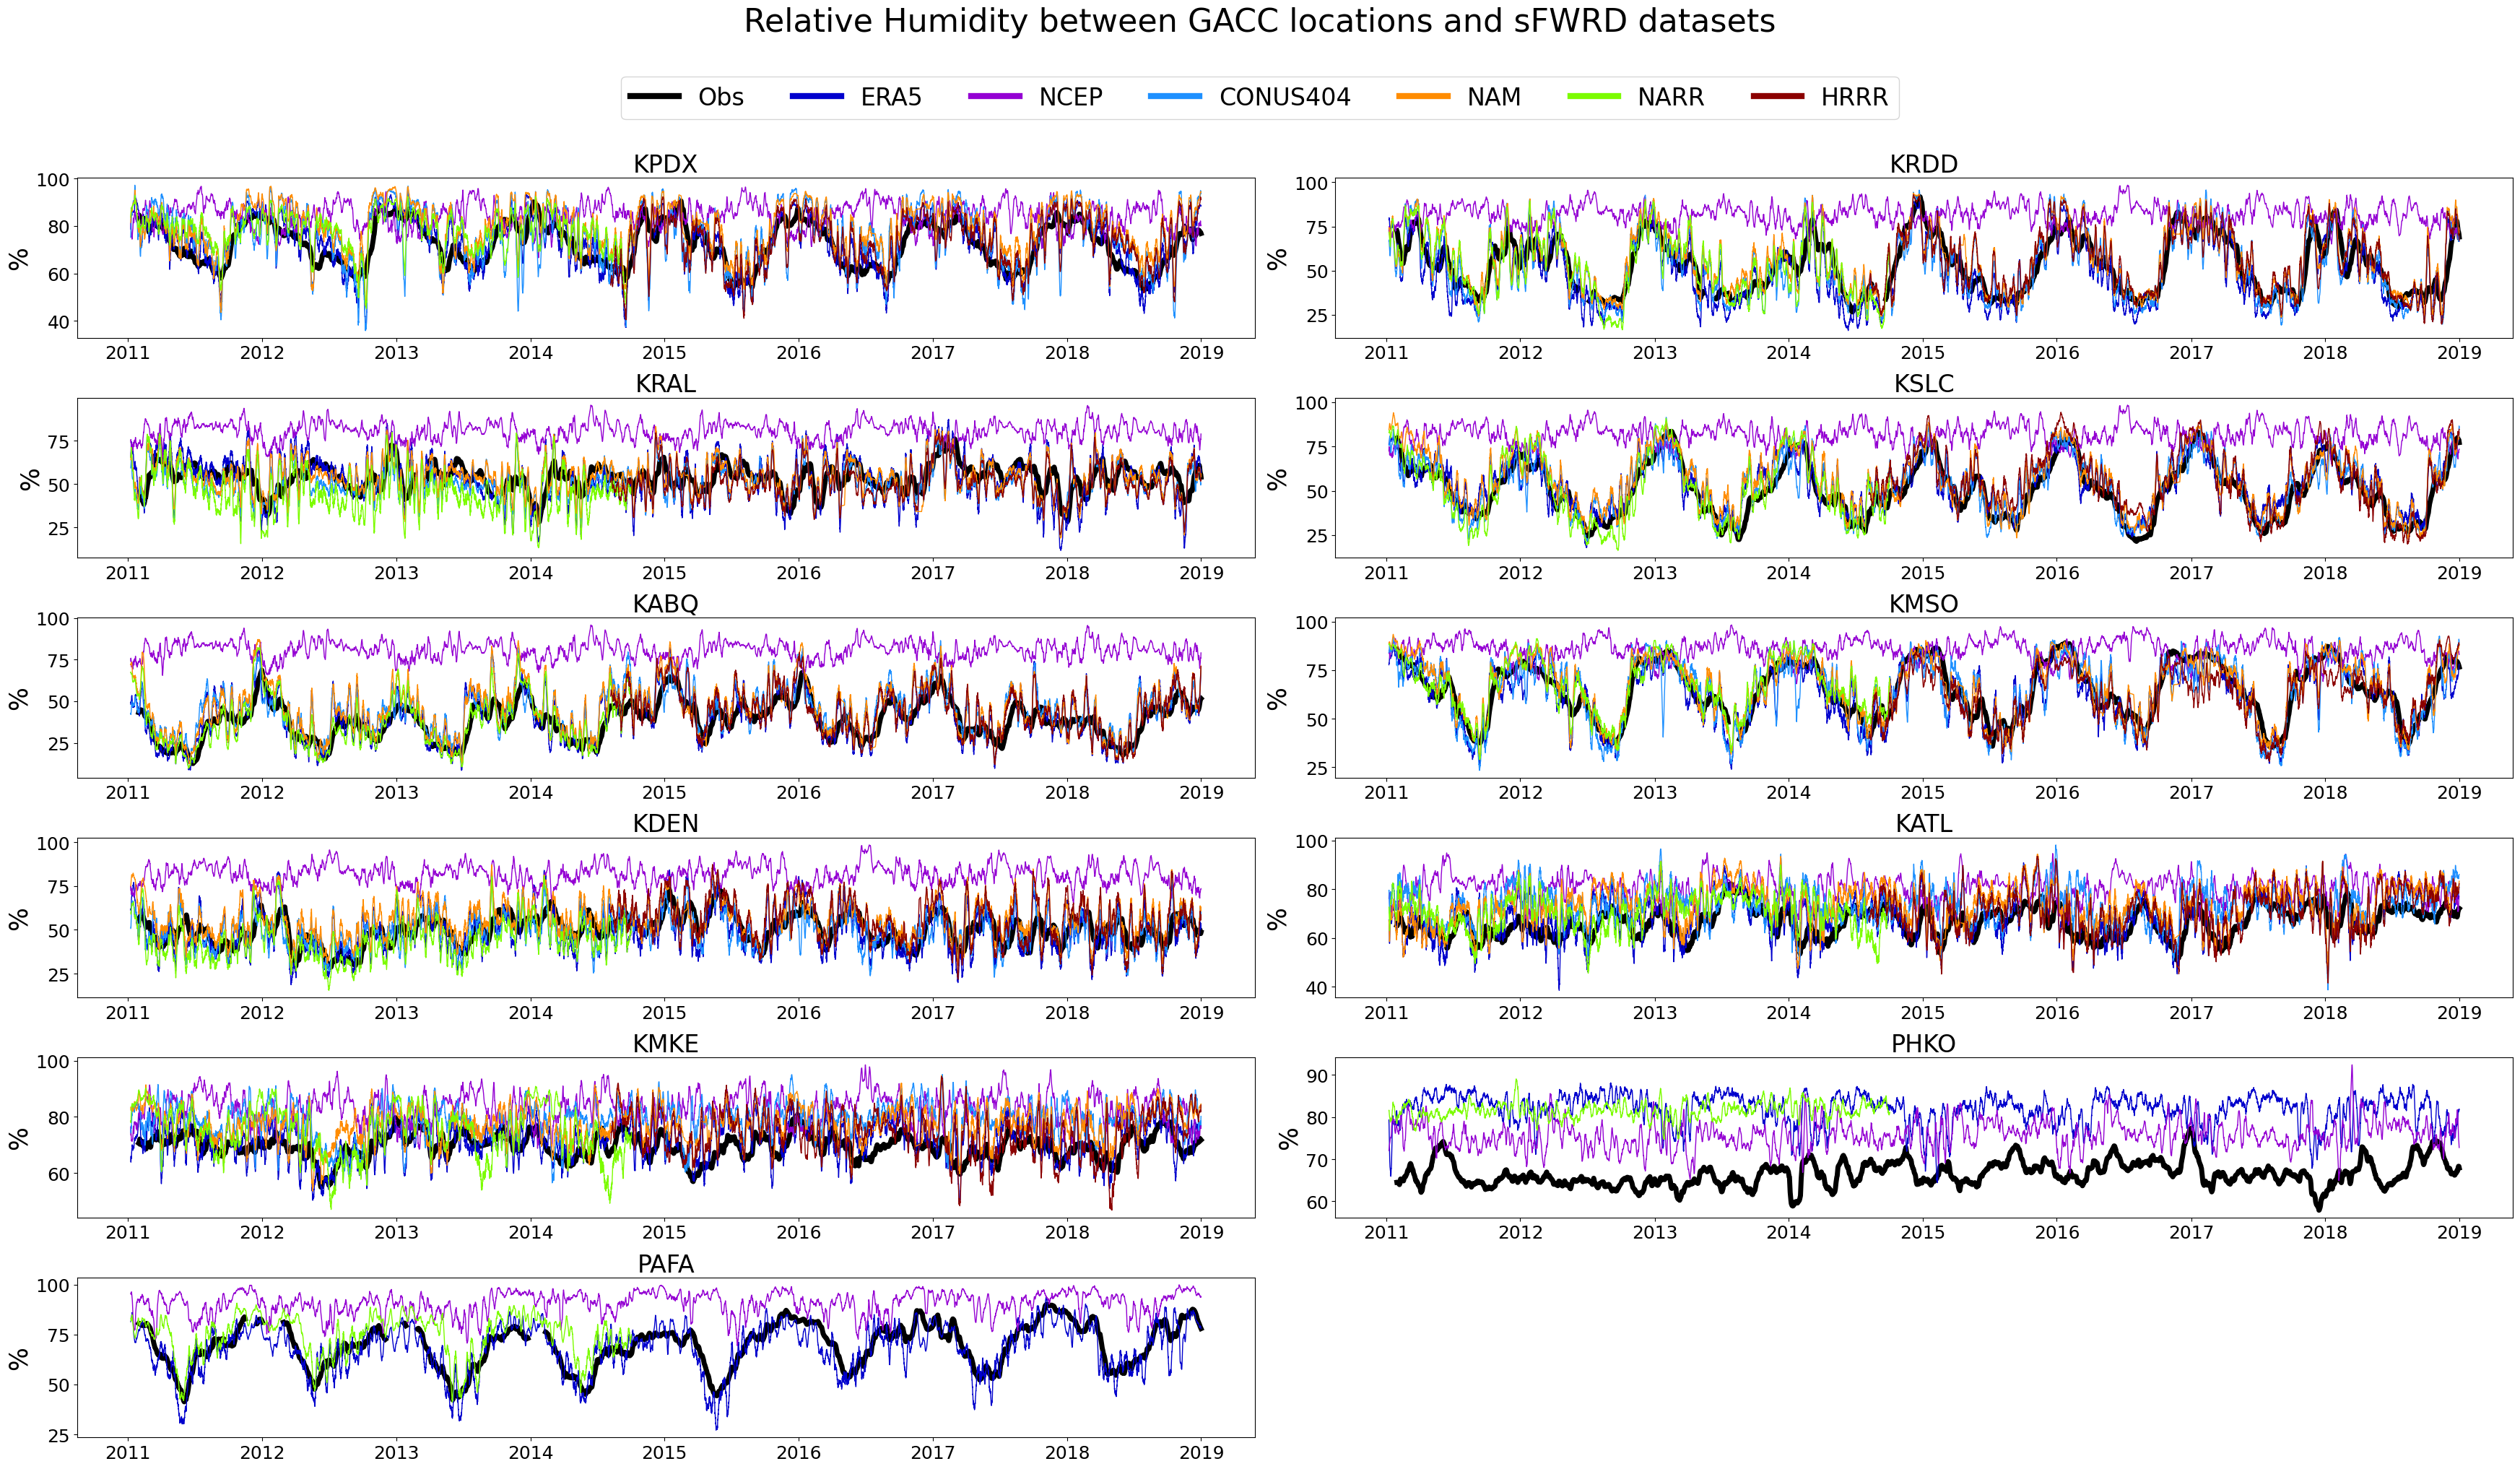

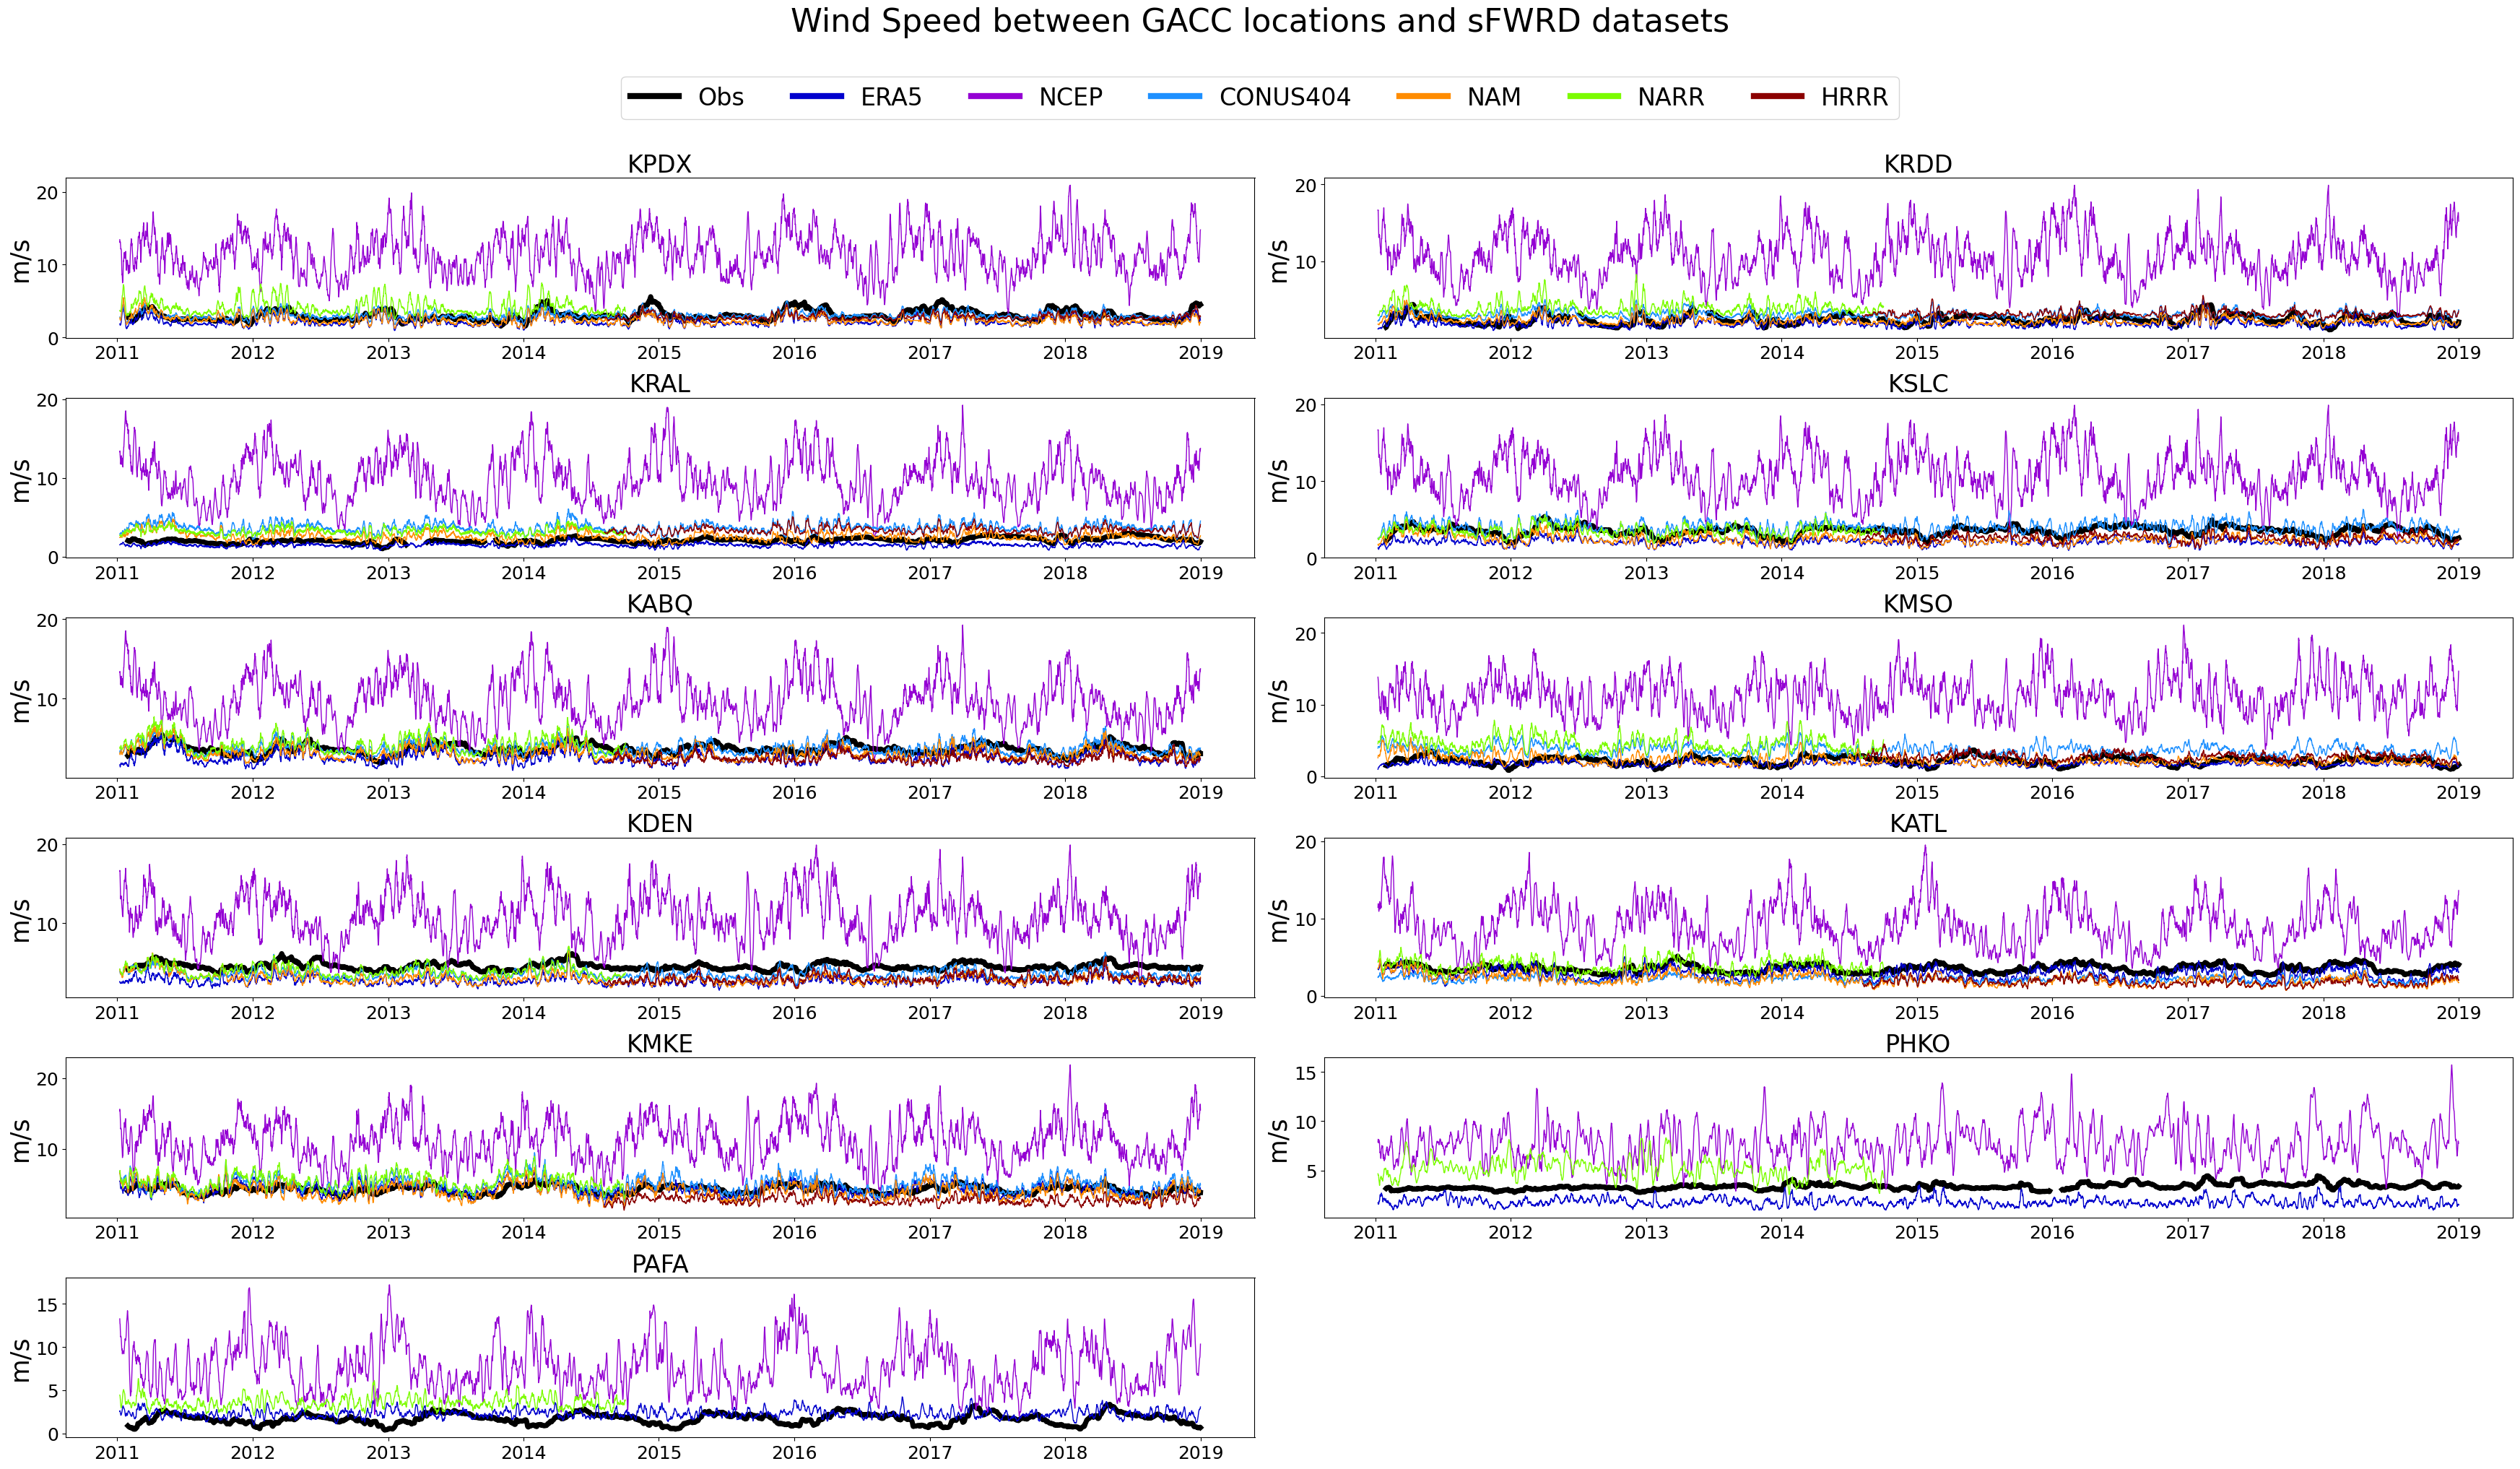

In [ ]:

for v in vars:                                                                                                                  # Loop through the variables in the list

    fig, axes = plt.subplots(6, 2, figsize = (35, 20))                                                                          # Create a figure with a 6x2 grid of subplots
    window_size = 30                                                                                                            # Define the window size for rolling mean

    handles_dict = {}                                                                                                           # Initialize a dictionary to store plot handles
    labels_dict = {}                                                                                                            # Initialize a dictionary to store plot labels
    
    for s, ax in enumerate(axes.flatten()):                                                                                     # Loop through each subplot axis
    
        if s == 11:                                                                                                             # If it's the last subplot
            ax.axis('off')                                                                                                      # Turn off the axis
        else:                                                                                                                   # Otherwise
            site_obs = to_plot[ordered_sites[s]][0][v]                                                                          # Get the observation data for the site
            obs_lat = site_obs.latitude.values                                                                                  # Get the latitude values
            obs_lon = site_obs.longitude.values                                                                                 # Get the longitude values
    
            obs_plot = convert(site_obs[v].rolling(time=window_size).mean(), v, 'obs', m = None)                                # Convert and smooth the observation data
            
            obs_handle, = ax.plot(site_obs.time, obs_plot, c='k', label='Obs', linewidth=5)                                     # Plot the observation data
            
            if 'Obs' not in labels_dict:                                                                                        # If 'Obs' label is not in the dictionary
                handles_dict[sitename] = obs_handle                                                                             # Add the handle to the dictionary
                labels_dict[sitename] = 'Obs'                                                                                   # Add the label to the dictionary
            
            for m in models:                                                                                                    # Loop through each model
                try:                                                                                                            # Try to plot the model data
                    mod_var = var_plot_dict[v][0]                                                                               # Get the model variable
                    mod_var_plot = to_plot[ordered_sites[s]][1][v][m]                                                           # Get the model data
                                        
                    mod_plot = convert(mod_var_plot[mod_var].rolling(time=window_size).mean(), v, 'mod', m = m)                 # Convert and smooth the model data

                    mod_handle, = ax.plot(mod_var_plot.time, mod_plot, c=get_line_plot_colors(m), label=m, linewidth=1)         # Plot the model data
                    
                    if m not in labels_dict:                                                                                    # If model label is not in the dictionary
                        handles_dict[m] = mod_handle                                                                            # Add the handle to the dictionary
                        labels_dict[m] = m                                                                                      # Add the label to the dictionary
                    
                except:                                                                                                         # If an error occurs
                    print(f'{m}: {v} is not available')                                                                         # Print an error message
                    
            ax.set_ylabel(var_plot_dict[v][2], fontsize=25)                                                                     # Set the y-axis label
            ax.tick_params(axis='both', labelsize=18)                                                                           # Set the tick parameters
            ax.set_title(ordered_sites[s], fontsize=24)                                                                         # Set the subplot title
    
    handles_list = list(handles_dict.values())                                                                                  # Get the list of handles
    labels_list = list(labels_dict.values())                                                                                    # Get the list of labels

    thicker_handles = [plt.Line2D([], [], color=handle.get_color(), linewidth=6) for handle in handles_list]                    # Create thicker handles for the legend
        
    fig.legend(handles=thicker_handles, labels=labels_list, prop={'size': 24}, loc='upper center',                              # Add the legend
               ncol=len(models) + 1, bbox_to_anchor=(0.5, 0.975))  
    fig.suptitle(f'{var_plot_dict[v][1]} between GACC locations and sFWRD datasets', y =1.015, size = 32)                       # Add the figure title

    plt.tight_layout(rect=[0, 0, 1, 0.95])                                                                                      # Adjust the layout

    plt.savefig(f'obs/GACC_plots/{v}.png', bbox_inches = 'tight')                                                               # Save the figure

    plt.show()                                                                                                                  # Show the figure

# One Station, One Variable, Multiple Times

## Get observation files by variable and station

In [4]:
sites = pd.read_csv('obs/SiteList_LatLon.csv', sep = ',')

FileNotFoundError: [Errno 2] No such file or directory: 'obs/SiteList_LatLon.csv'

In [ ]:
site_list = sites['Site'].values
site_list

In [5]:
sitename = 'KPDX'
times = ['Daily', 'Abs']
mma = ['MAX', 'MIN', 'AVG']

obs_to_mod_var = {'hdwi': 'hdw'}

In [6]:
models =  ['ERA5', 'NCEP', 'CONUS404', 'NAM', 'NARR', 'HRRR']

In [10]:
%%time                                                                                                                                
                          
to_plot = {}
site_mod = {}
site_obs = {}                           

for t in times:                                                                                                                       # Loop through each site name in site_list
                                                        
    print(f'{t} IS STARTING')                                                                                                  # Print a message indicating the start of processing for the current site
    
    for obs_v, mod_v in obs_to_mod_var.items():                                                                                       # Loop through each observation variable and its corresponding model variable
        
        if t == 'Abs':
        
            obs = xr.open_mfdataset(glob.glob(os.path.join('../../../../../obs/database_like_files', f'{obs_v}*{sitename}*{t}*.nc')))                    # Open the observation dataset for the current variable and site
            site_obs[f'{obs_v}_Abs'] = obs

        else:

            for mm in mma:

                obs = xr.open_mfdataset(glob.glob(os.path.join('../../../../../obs/database_like_files', f'{obs_v}{mm}*{sitename}*{t}*.nc')))                    # Open the observation dataset for the current variable and site
                site_obs[f'{obs_v}_{mm}'] = obs
                        
        for m in models:                                                                                                              # Loop through each model
                                                        
            print(f'{m}: {mod_v}')                                                                                                    # Print a message indicating the current model and variable

            try:

                mod = xr.open_dataset(f'../../../../../obs/model_by_site/{sitename}/{m}/{mod_v}_{m}_{sitename}.nc')
                
                if t == 'Abs':
                    site_mod[f'{m}_Abs'] = mod      

                else:

                    model_24 = mod[mod_v].resample(time='24H').mean(dim='time', skipna = True).to_dataset()
                    model_min = mod[mod_v].resample(time='24H').min(dim='time', skipna = True).to_dataset()
                    model_max = mod[mod_v].resample(time='24H').max(dim='time', skipna = True).to_dataset()
                     
                    site_mod[f'{m}_AVG'] = model_24      
                    site_mod[f'{m}_MIN'] = model_min      
                    site_mod[f'{m}_MAX'] = model_max      
                                
            except:                                                                                                                    # Handle exceptions
                             
                print(f'{m}: {mod_v} is not available')                                                                                # Print a message indicating the model variable is not available                         
                                                                                                                                       # Delete the selected model data to free up memory
    to_plot[sitename] = [site_obs, site_mod]


Daily IS STARTING
ERA5: hdw
NCEP: hdw
CONUS404: hdw
NAM: hdw
NARR: hdw
HRRR: hdw
Abs IS STARTING
ERA5: hdw
NCEP: hdw
CONUS404: hdw
NAM: hdw
NARR: hdw
HRRR: hdw
CPU times: user 16.3 s, sys: 36.1 ms, total: 16.4 s
Wall time: 16.5 s


## Plotting 

In [12]:
var_plot_dict = {'hdwi': ['hdw', 'Surface Based Hot-Dry-Windy', '']}

In [55]:
vars = list(var_plot_dict.keys())

In [17]:
plot_order = ['MAX', 'MIN', 'AVG', 'Abs'] 
obs_keys = list(to_plot[sitename][0].keys())

In [50]:
v = 'hdwi'

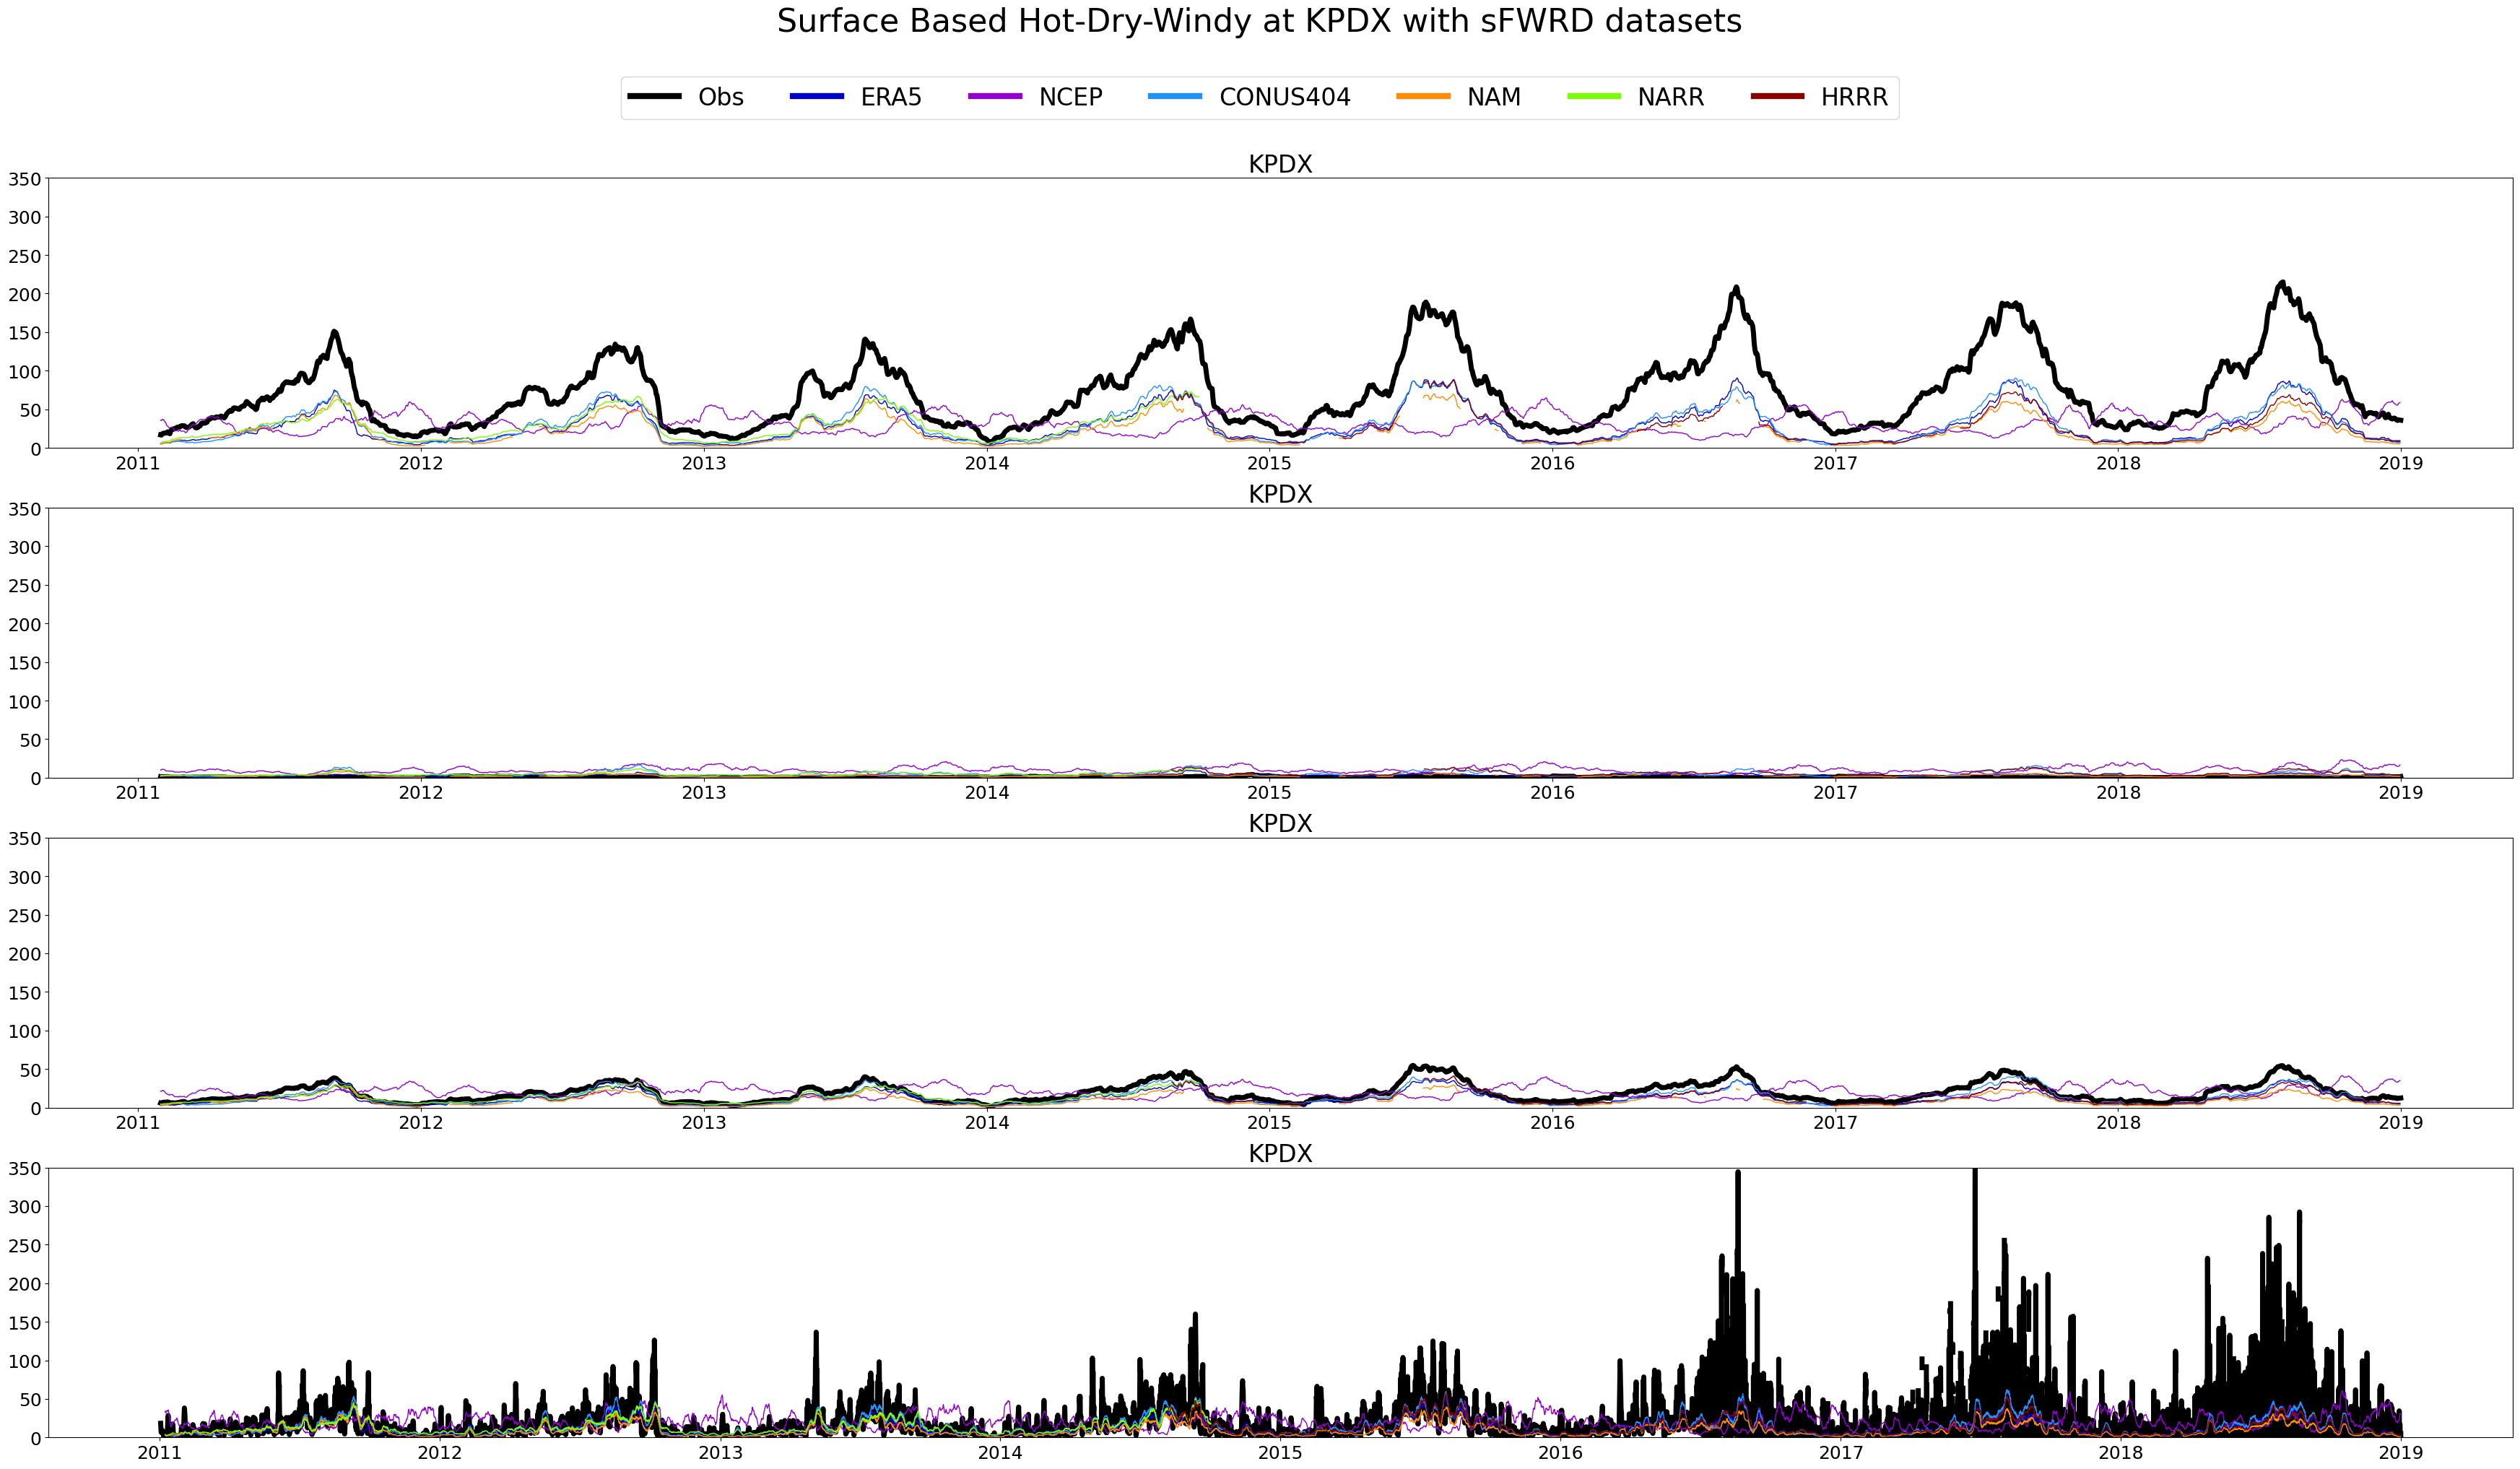

In [61]:
fig, axes = plt.subplots(4, 1, figsize = (35, 20))                                                                          # Create a figure with a 6x2 grid of subplots
window_size = 30                                                                                                            # Define the window size for rolling mean

handles_dict = {}                                                                                                           # Initialize a dictionary to store plot handles
labels_dict = {}                                                                                                            # Initialize a dictionary to store plot labels

for s, ax in enumerate(axes.flatten()):                                                                                     # Loop through each subplot axis

    po = plot_order[s]
    site_obs_key = next(key for key in obs_keys if po in key)        
    site_obs = to_plot[sitename][0][site_obs_key]                                                                                     # Get the observation data for the site

    obs_lat = site_obs.latitude.values                                                                                  # Get the latitude values
    obs_lon = site_obs.longitude.values                                                                                 # Get the longitude values

    obs_plot = convert(site_obs[v].rolling(time=window_size).mean(), v, 'obs', m = None)                                                                 # Convert and smooth the observation data
    
    obs_handle, = ax.plot(site_obs.time, obs_plot, c='k', label='Obs', linewidth=5)                                     # Plot the observation data
    
    if 'Obs' not in labels_dict:                                                                                        # If 'Obs' label is not in the dictionary
        handles_dict[sitename] = obs_handle                                                                             # Add the handle to the dictionary
        labels_dict[sitename] = 'Obs'                                                                                   # Add the label to the dictionary
    
    for m in models:                                                                                                    # Loop through each model
        try:                                                                                                            # Try to plot the model data
            mod_var = to_plot[sitename][1]                                                                               # Get the model variable
            mod_var_plot = to_plot[sitename][1][f'{m}_{po}']                                                            # Get the model data
                                
            mod_plot = convert(mod_var_plot[obs_to_mod_var[v]].rolling(time=window_size).mean(), v, 'mod', m = m)                                                  # Convert and smooth the model data
    
            mod_handle, = ax.plot(mod_var_plot.time, mod_plot, c=get_line_plot_colors(m), label=m, linewidth=1)         # Plot the model data
            
            if m not in labels_dict:                                                                                    # If model label is not in the dictionary
                handles_dict[m] = mod_handle                                                                            # Add the handle to the dictionary
                labels_dict[m] = m                                                                                      # Add the label to the dictionary
                
        except:                                                                                                         # If an error occurs
            print(f'{m}: {v} is not available')                                                                         # Print an error message

    ax.set_ylim(0, 350)
    ax.set_ylabel(var_plot_dict[v][2], fontsize=25)                                                                     # Set the y-axis label
    ax.tick_params(axis='both', labelsize=18)                                                                           # Set the tick parameters
    ax.set_title(sitename, fontsize=24)                                                                         # Set the subplot title

handles_list = list(handles_dict.values())                                                                                  # Get the list of handles
labels_list = list(labels_dict.values())                                                                                    # Get the list of labels

thicker_handles = [plt.Line2D([], [], color=handle.get_color(), linewidth=6) for handle in handles_list]                    # Create thicker handles for the legend
    
fig.legend(handles=thicker_handles, labels=labels_list, prop={'size': 24}, loc='upper center',                              # Add the legend
           ncol=len(models) + 1, bbox_to_anchor=(0.5, 0.975))  
fig.suptitle(f'{var_plot_dict[v][1]} at {sitename} with sFWRD datasets', y =1.015, size = 32)                       # Add the figure title

plt.tight_layout(rect=[0, 0, 1, 0.95])                                                                                      # Adjust the layout

#plt.savefig(f'obs/GACC_plots/{v}.png', bbox_inches = 'tight')                                                               # Save the figure

plt.show()                                                                                                                  # Show the figure

# One Station, Multiple Variables